# Screen Read and Parse
### Minimal streaming example (Ollama)
##### Dr John Hughes

#### Sample UI screenshot

This establishes the task context the model will “see.” No traces; it’s just the visual anchor for later steps.

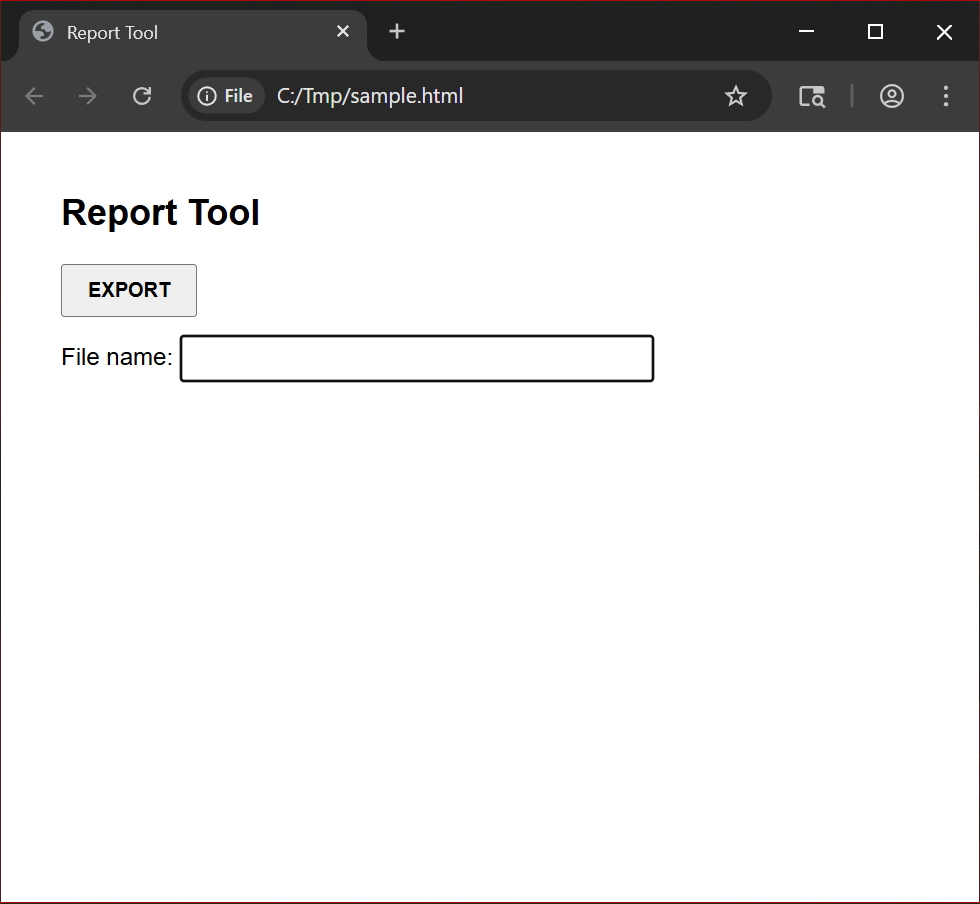

In [14]:
import os, sys, json, re
from pathlib import Path
from IPython.display import display
from PIL import Image
import ollama, time

# Allow "from src...." imports when running this notebook
sys.path.append(os.path.abspath("."))

IMG = Path("../assets/sample.png")
INSTRUCTION = "Click the 'Export' button, then type 'report.pdf' and press Enter."

assert IMG.exists(), f"Missing image: {IMG}. Create it (see instructions) and save here."

display(Image.open(IMG).convert("RGB"))

### System prompt with Few Shot exemplars 

Builds a strict system prompt and two few-shot exemplars that nail the JSON shape. Streams a single model reply (Ollama) and prints the raw JSON. This  demonstrates that VLMs sometimes collapse steps into one dict which is useful for showing why we need to normalize below. There are no traces yet.

The system prompt and few_shot assistants help nudge Ollama into recording the information we want form the screenshot.

##### System Prompt

An extra nudge could be added to the system prompt like this:
```
“Do not include text or keys on the click step; the type.text must equal the instructed filename exactly; the hotkey must include only enter unless explicitly instructed otherwise.”
```

##### Few Shots

The few shot exemplars  and schema hint anchor the exact array shape desired. 

In [15]:
system = (
  "You are a UI agent. Output ONLY valid JSON.\n"
  "Return a JSON array of exactly 3 steps in this order: click, type, hotkey—even if the field appears pre-filled.\n"

  "Schema per item:\n"
  '  {"action":"click|type|hotkey", "target":"string", "text":"optional", "keys":"optional array"}\n'
  "Never include prose, code fences, or comments.\n"
  'The type.text must be a non-empty filename string; the hotkey.keys must include "enter".'
)

# Tiny few-shots (no image needed) to lock structure:
fewshot_user = {
  "role": "user",
  "content": "Click 'Save', then type 'output.txt' and press Enter."
}
fewshot_assistant = {
  "role": "assistant",
  "content": (
    '[{"action":"click","target":"button:SAVE"},'
    ' {"action":"type","target":"input:File name","text":"output.txt"},'
    ' {"action":"hotkey","target":"system","keys":["enter"]}]'
  )
}

fewshot2_user = {
  "role": "user",
  "content": "Click the 'Upload' button, then type 'data.csv' and press Enter."
}
fewshot2_assistant = {
  "role": "assistant",
  "content": (
    '[{"action":"click","target":"button:UPLOAD"},'
    ' {"action":"type","target":"input:File name","text":"data.csv"},'
    ' {"action":"hotkey","target":"system","keys":["enter"]}]'
  )
}

user = {
  "role": "user",
  "content": INSTRUCTION,
  "images": [IMG]
}

schema_hint = {
  "role": "user",
  "content": (
    'Return exactly 3 steps:\n'                       # For a harder push try: "Return exactly this structure (no prose):"
    '[{"action":"click","target":"button:EXPORT"},'
    ' {"action":"type","target":"input:File name","text":"report.pdf"},'
    ' {"action":"hotkey","target":"system","keys":["enter"]}]'
  )
}

chunks = []
resp = ollama.chat(
    model="llama3.2-vision",
    messages=[{"role":"system","content":system}, 
              fewshot_user, fewshot_assistant,           # SAVE/output.txt example
              fewshot2_user, fewshot2_assistant,         # UPLOAD/data.csv example
              user, schema_hint],
    stream=True,
    format="json",                              # force valid JSON
    options={"temperature": 0.0, "top_p": 0.1}  # deterministic
)

for ch in resp:
    part = ch.get("message", {}).get("content", "")
    if part:
        print(part, end="", flush=True)
        chunks.append(part)

raw = "".join(chunks)
print("\n\nRAW:", raw)

{"action":"click","target":"button:EXPORT","text":"report.pdf","keys":["enter"],"type":"type"}

RAW: {"action":"click","target":"button:EXPORT","text":"report.pdf","keys":["enter"],"type":"type"}


### Coerce_plan and Validator

Parses the raw text, coerces it into exactly `[click, type, hotkey]`, and validates: non-empty filename for `type`, and `"enter"` in `hotkey`. Prints the canonical plan and a boolean `Valid`. This is the bridge to policy controls. Everything downstream expects this normalized, safe plan.

##### Validator

The validator enforces non-empty text and "enter" in keys. This could be stricter, for example, adding filename sanity checks (e.g., endswith(".pdf")).

In [29]:
def extract_json(s: str):
    try:
        return json.loads(s)
    except Exception:
        m = re.search(r'(\[.*\]|\{.*\})', s, re.DOTALL)
        if m: return json.loads(m.group(1))
        raise

def coerce_plan(obj, filename="report.pdf"):
    """Coerce a dict or misordered list into [click, type, hotkey] with allowed fields only."""
    def click_step(target="button:EXPORT"):
        return {"action":"click","target":target}
    def type_step(target="input:File name", text=None):
        return {"action":"type","target":target,"text":text}
    def hotkey_step(keys=None):
        if not keys: keys = ["enter"]
        return {"action":"hotkey","target":"system","keys":keys}

    if isinstance(obj, dict):
        # Split merged fields from a single dict into 3 separate steps.
        tgt  = obj.get("target","button:EXPORT")
        txt  = obj.get("text", filename)
        keys = obj.get("keys", ["enter"])
        return [click_step(tgt), type_step("input:File name", txt), hotkey_step(keys)]

    if isinstance(obj, list):
        # Normalize into exactly [click, type, hotkey] and strip illegal fields
        want = ["click","type","hotkey"]
        out = [None, None, None]
        for a in obj:
            if not isinstance(a, dict): continue
            act = a.get("action")
            if act == "click" and out[0] is None:
                out[0] = click_step(a.get("target","button:EXPORT"))
            elif act == "type" and out[1] is None:
                out[1] = type_step(a.get("target","input:File name"), a.get("text", filename))
            elif act == "hotkey" and out[2] is None:
                out[2] = hotkey_step(a.get("keys", ["enter"]))
        # Fill any missing steps
        if out[0] is None: out[0] = click_step()
        if out[1] is None: out[1] = type_step(text=filename)
        if out[2] is None: out[2] = hotkey_step()
        return out

    # Fallback to the canonical 3 steps
    return [click_step(), type_step(text=filename), hotkey_step()]

def validate(plan):
    if not isinstance(plan, list) or len(plan) != 3: return False
    c,t,h = plan

    # click
    if c.get("action")!="click" or not c.get("target") or any(k in c for k in ("text","keys")):
        return False

    # type (non-empty text)
    if t.get("action")!="type" or not t.get("target") or not t.get("text") or "keys" in t:
        return False

    # hotkey (must include "enter")
    if h.get("action")!="hotkey" or h.get("target")!="system":
        return False
    keys = h.get("keys")
    if not isinstance(keys, list) or "enter" not in keys:
        return False

    return True

raw = "".join(chunks)
obj = extract_json(raw)
plan = coerce_plan(obj, filename="report.pdf")
print("Parsed plan:")
for p in plan:
   print(p)
print("\nValid:", validate(plan))

Parsed plan:
{'action': 'click', 'target': 'button:EXPORT'}
{'action': 'type', 'target': 'input:File name', 'text': 'report.pdf'}
{'action': 'hotkey', 'target': 'system', 'keys': ['enter']}

Valid: True
